# Identificación de operadores ineficases en CallMeMaybe

## Definición del problema

### Objetivo clave de proyecto

Se busca mejorar la eficiencia operativa del servicio telefónico de CallMeMaybe realizando un análisis para poder detectar operadores que se consideren ineficientes tomando ciertas características tales como un alto número de llamadas entrantes, tiempo de espera prolongado para atender las llamadas o un bajo numero de llamadas salientes si son parte de sus responsabilidades.

### Preguntas clave

Para poder detectar los operadores ineficientes se necesita establecer las siguientes preguntas.

- ¿Cuáles son los puntos clave que indican la ineficiencia en los operadores?
- ¿Existen patrones que determinen la ineficiencia de los operadores?
- ¿Comparten alguna característica los operadores ineficientes?
- ¿Que porcentaje de llamadas tienden a perderse por cada operador?
- ¿Qué relacion existe entre el tiempo promedio de espera y el numero de llamadas perdidas por operador?

## Importación de librerías

In [1104]:
import pandas as pd
from scipy import stats
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

## Lectura de datos

### Lectura de fuente de datos

In [1107]:
df_clients = pd.read_csv(r'C:\Users\i15he\final_project\telecom_clients_us.csv')
df_info = pd.read_csv(r'C:\Users\i15he\final_project\telecom_dataset_us.csv')

## Análisis inicial

### Clientes

In [1110]:
df_clients.head(10)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
5,167764,A,2019-09-30
6,167050,A,2019-08-29
7,168252,A,2019-10-17
8,168495,A,2019-10-28
9,167879,A,2019-10-03


In [1111]:
df_clients['tariff_plan'].unique()

array(['A', 'C', 'B'], dtype=object)

In [1112]:
df_clients.describe()

,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


In [1113]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


### Operadores

In [1115]:
df_info.head(10)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0,35
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
9,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0,62


In [1116]:
df_info.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


In [1117]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


El dataframe que contiene la información de las operadoras cuenta con valores nulos dentro de la columna operator_id y la columna internal

## Análisis exploratorio de datos

### Control de valores nulos y ausentes

#### Clientes

In [1122]:
df_clients.isnull().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

#### Operadores

In [1124]:
df_info.isnull().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

El dataframe de df_info, el cual contiene la información de los operadores telefónicos cuenta con ciertos valores ausentes

### Imputación de valores ausentes y nulos

#### Operadores

In [1128]:
df_info[df_info['internal'].isnull()]

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18 00:00:00+03:00,in,NaN,NaN,True,1,0,59
1090,166405,2019-10-01 00:00:00+03:00,in,NaN,NaN,True,1,0,1
1864,166406,2019-08-20 00:00:00+03:00,in,NaN,NaN,True,1,0,36
1924,166406,2019-09-02 00:00:00+03:00,in,NaN,879898.0,False,1,2,9
6210,166541,2019-09-26 00:00:00+03:00,in,NaN,908960.0,False,1,393,423
...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,6,0,14
52590,168361,2019-11-13 00:00:00+03:00,in,NaN,NaN,True,2,0,6
52621,168361,2019-11-14 00:00:00+03:00,in,NaN,NaN,True,1,0,2
53717,168579,2019-11-09 00:00:00+03:00,in,NaN,NaN,True,1,0,18


Se valida que la cantidad de valores nulos que tiene la columna de "internal" son muy pocos se puede proceder a eliminarlos, ya que representan una porcion muy pequeña del total

In [1130]:
df_operators = df_info.dropna(subset=['internal'])

In [1131]:
df_operators.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53785 non-null  int64  
 1   date                 53785 non-null  object 
 2   direction            53785 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45670 non-null  float64
 5   is_missed_call       53785 non-null  bool   
 6   calls_count          53785 non-null  int64  
 7   call_duration        53785 non-null  int64  
 8   total_call_duration  53785 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.7+ MB


In [1132]:
df_operators.loc[:, 'operator_id'] = df_operators.groupby(['user_id', 'direction'])['operator_id'].apply(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else -1)
).reset_index(level=['user_id', 'direction'], drop=True)

df_operators

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,880028.0,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25
...,...,...,...,...,...,...,...,...,...
53897,168606,2019-11-10 00:00:00+03:00,out,True,957922.0,True,1,0,38
53898,168606,2019-11-11 00:00:00+03:00,out,True,957922.0,False,2,479,501
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190
53900,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190


Para imputar los valores nulos dentro de la columna "operator_id" se busca al operador que realizó la mayoria de llamadas en dirección in, esto para buscar el operador más comun para cada user_id, en caso de no encontrar alguno se asignará el valor -1

### Valoración y renombración de columnas 

#### Clientes

In [1136]:
df_clients.rename(columns={'user_id': 'id_cliente', 'tariff_plan': 'plan', 'date_start': 'fecha_inicio'}, inplace=True)


#### Operadores 

In [1138]:
df_operators = df_operators.copy()
df_operators.rename(columns={
    'user_id': 'id_cliente', 
    'date': 'fecha_llamada', 
    'direction': 'direccion', 
    'operator_id': 'id_operador', 
    'is_missed_call': 'llamada_perdida', 
    'calls_count': 'conteo_llamadas', 
    'call_duration': 'duracion_llamada', 
    'total_call_duration': 'duracion_total_llamadas'}, inplace=True)

### Comprobación de tipos de datos

### Conversión de tipos

#### Clientes

##### Conversión de tipo datetime en columna date_start

In [1143]:
df_clients['fecha_inicio'] = pd.to_datetime(df_clients['fecha_inicio'], format='%Y-%m-%d') 

In [1144]:
df_clients

,id_cliente,plan,fecha_inicio
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16
...,...,...,...
727,166554,B,2019-08-08
728,166911,B,2019-08-23
729,167012,B,2019-08-28
730,166867,B,2019-08-22


#### Operadores 

##### Conversión de tipo de dato a datetime de columna date

In [1147]:
df_operators['fecha_llamada'] = pd.to_datetime(df_operators['fecha_llamada'], format='%Y-%m-%d %H:%M:%S%z')
df_operators['fecha_llamada'] = df_operators['fecha_llamada'].dt.tz_localize(None)


##### Conversión de tipo de dato a int de columna operator_id

In [1149]:
df_operators['id_operador'] = df_operators['id_operador'].astype(int)

In [1150]:
df_operators.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53785 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id_cliente               53785 non-null  int64         
 1   fecha_llamada            53785 non-null  datetime64[ns]
 2   direccion                53785 non-null  object        
 3   internal                 53785 non-null  object        
 4   id_operador              53785 non-null  int32         
 5   llamada_perdida          53785 non-null  bool          
 6   conteo_llamadas          53785 non-null  int64         
 7   duracion_llamada         53785 non-null  int64         
 8   duracion_total_llamadas  53785 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int32(1), int64(4), object(2)
memory usage: 3.5+ MB


### Eliminación de duplicados

#### Operadores

In [1153]:
df_operators.drop_duplicates(inplace=True)

#### Clientes

In [1155]:
df_clients.drop_duplicates(inplace=True)

### Filtrado de usuarios en ambos grupos

In [1157]:
df_clients_count =  df_clients.groupby('id_cliente')['plan'].nunique()
clients_both_groups = df_clients_count[df_clients_count == 2].index.tolist()

df_clients = df_clients[~df_clients['id_cliente'].isin(clients_both_groups)]

## Propuesta de hipótesis

### Desarrollo de propuesta de hipotesis

H0: No existe una diferencia significativa en el número de llamadas perdidas entre los operadores considerados eficientes e ineficientes.

H1: Existe una diferencia significativa en el número de llamadas perdidas entre los operadores considerados eficientes e ineficientes.

## Análisis exploratorio de datos

### Obtención de datos necesarios para prueba de hipótesis

In [1163]:
df_merge = df_clients.merge(
    df_operators,
    on='id_cliente',
    how='inner' 
)

# Crear la columna de tiempo de espera como la diferencia entre duracion_total_llamadas y duracion_llamada
df_merge['tiempo_espera'] = df_merge['duracion_total_llamadas'] - df_merge['duracion_llamada']

df_merge


,id_cliente,plan,fecha_inicio,fecha_llamada,direccion,internal,id_operador,llamada_perdida,conteo_llamadas,duracion_llamada,duracion_total_llamadas,tiempo_espera
0,166713,A,2019-08-15,2019-08-21,in,False,891908,True,4,0,8,8
1,166713,A,2019-08-15,2019-08-22,in,False,891918,False,1,40,62,22
2,166713,A,2019-08-15,2019-08-22,in,False,891908,False,4,538,568,30
3,166713,A,2019-08-15,2019-08-22,in,False,891908,True,4,0,8,8
4,166713,A,2019-08-15,2019-08-26,in,False,891908,False,1,713,727,14
...,...,...,...,...,...,...,...,...,...,...,...,...
48884,167012,B,2019-08-28,2019-08-30,out,False,899076,True,1,0,25,25
48885,167012,B,2019-08-28,2019-08-30,out,True,898434,True,1,0,33,33
48886,167012,B,2019-08-28,2019-08-30,in,False,-1,True,2,0,11,11
48887,167012,B,2019-08-28,2019-08-30,out,True,899076,True,1,0,22,22


In [1164]:
# Agrupación para obtener las métricas solicitadas por operador
operatorsGroup = df_merge.groupby('id_operador').agg(
    total_llamadas=('conteo_llamadas', 'sum'),  # Total de llamadas
    duracion_promedio_llamadas=('duracion_llamada', 'mean'),  # Duración promedio de llamadas
    llamadas_perdidas=('llamada_perdida', 'sum'),  # Total de llamadas perdidas
    tiempo_promedio_espera=('tiempo_espera', 'mean')  # Tiempo de espera promedio
).reset_index()

# Agrupación para obtener el total de llamadas entrantes y salientes
llamadas_direccion = df_merge.groupby(['id_operador', 'direccion']).agg(
    total_llamadas=('conteo_llamadas', 'sum')
).unstack(fill_value=0).reset_index()

# Cambiar los nombres de las columnas para mayor claridad
llamadas_direccion.columns = ['id_operador', 'llamadas_entrantes', 'llamadas_salientes']

# Combinar los DataFrames en uno solo
operatorsGroup = operatorsGroup.merge(llamadas_direccion, on='id_operador')

operatorsGroup


,id_operador,total_llamadas,duracion_promedio_llamadas,llamadas_perdidas,tiempo_promedio_espera,llamadas_entrantes,llamadas_salientes
0,-1,20463,0.000000,312,321.528846,20463,0
1,879896,930,545.829060,47,104.914530,58,872
2,879898,7407,919.246429,143,382.878571,198,7209
3,880020,45,112.250000,6,14.000000,7,38
4,880022,197,216.385714,29,53.971429,8,189
...,...,...,...,...,...,...,...
1088,972410,77,944.250000,2,374.500000,0,77
1089,972412,61,699.600000,2,210.000000,1,60
1090,972460,51,174.000000,3,88.571429,1,50
1091,973120,3,2.500000,1,10.000000,0,3


### Análisis de correlaciones de llamadas y distribución

In [1166]:
# Seleccionar las columnas numéricas relevantes
columnas_numericas = ['total_llamadas', 'duracion_promedio_llamadas', 'llamadas_perdidas', 
                      'tiempo_promedio_espera', 'llamadas_entrantes', 'llamadas_salientes']

# Crear un nuevo DataFrame con esas columnas
df_correlacion = operatorsGroup[columnas_numericas]

# Calcular la matriz de correlación
matriz_correlacion = df_correlacion.corr()

# Imprimir la matriz de correlación
matriz_correlacion

,total_llamadas,duracion_promedio_llamadas,llamadas_perdidas,tiempo_promedio_espera,llamadas_entrantes,llamadas_salientes
total_llamadas,1.000000,0.598412,0.432830,0.649665,0.463793,0.939028
duracion_promedio_llamadas,0.598412,1.000000,0.171854,0.826763,0.102843,0.629726
llamadas_perdidas,0.432830,0.171854,1.000000,0.141772,0.437627,0.314504
tiempo_promedio_espera,0.649665,0.826763,0.141772,1.000000,0.098994,0.688574
llamadas_entrantes,0.463793,0.102843,0.437627,0.098994,1.000000,0.130893
llamadas_salientes,0.939028,0.629726,0.314504,0.688574,0.130893,1.000000


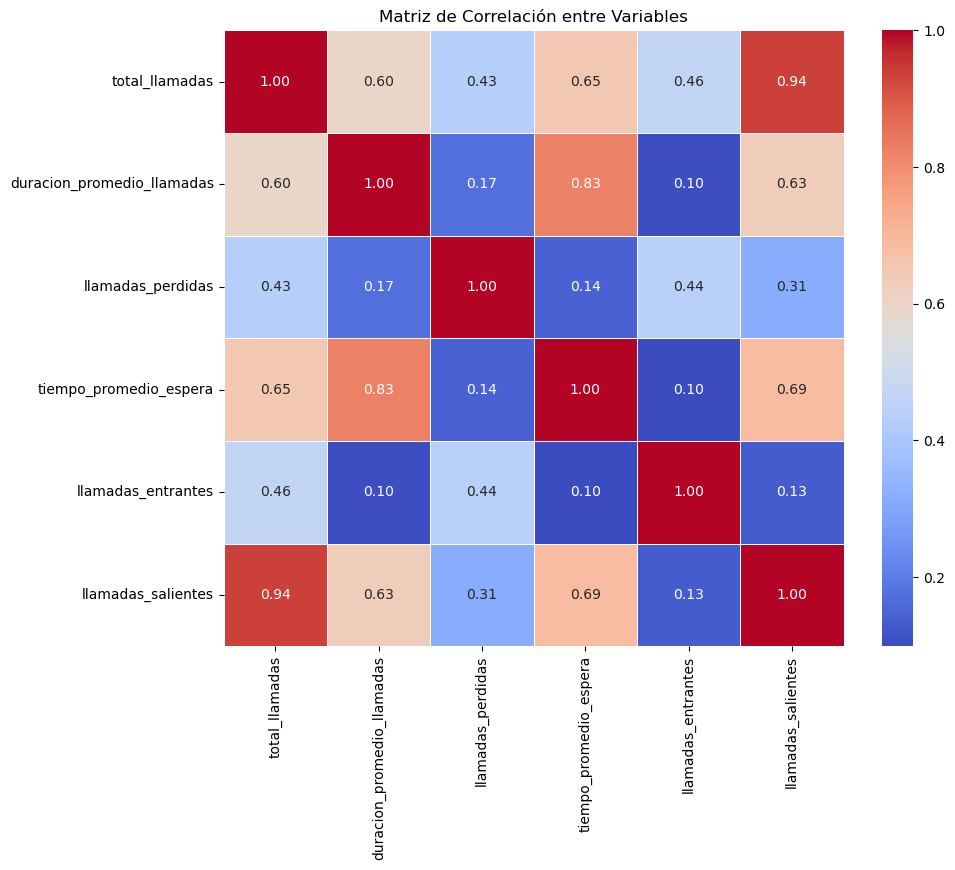

In [1167]:
# Visualizar la matriz de correlación usando un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()

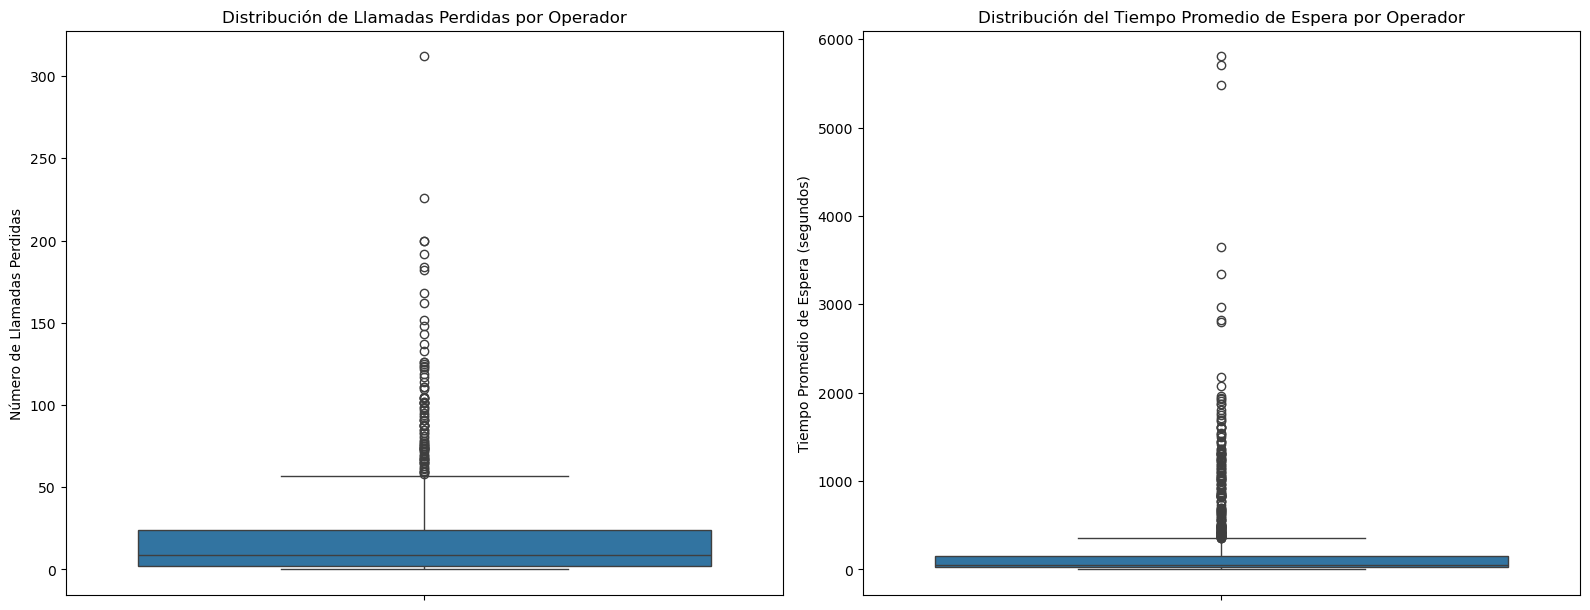

In [1168]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(16, 12))

# Diagrama de caja para 'llamadas_perdidas'
plt.subplot(2, 2, 1)  # Primer gráfico en la misma fila
sns.boxplot(data=operatorsGroup, y='llamadas_perdidas')
plt.title('Distribución de Llamadas Perdidas por Operador')
plt.ylabel('Número de Llamadas Perdidas')

# Diagrama de caja para 'tiempo_promedio_espera'
plt.subplot(2, 2, 2)  # Segundo gráfico en la misma fila
sns.boxplot(data=operatorsGroup, y='tiempo_promedio_espera')
plt.title('Distribución del Tiempo Promedio de Espera por Operador')
plt.ylabel('Tiempo Promedio de Espera (segundos)')

# Mostrar el gráfico
plt.tight_layout()  # Ajustar para que no se sobrepongan los gráficos
plt.show()

In [1171]:
# Definir los umbrales de percentiles para la clasificación
llamadas_perdidas_threshold = operatorsGroup['llamadas_perdidas'].quantile(0.75)
tiempo_espera_threshold = operatorsGroup['tiempo_promedio_espera'].quantile(0.75)
llamadas_salientes_threshold = operatorsGroup['llamadas_salientes'].quantile(0.50)

# Clasificación de operadores
operatorsGroup['eficiencia'] = operatorsGroup.apply(
    lambda row: 'ineficiente' if (row['llamadas_perdidas'] > llamadas_perdidas_threshold and
                                   row['tiempo_promedio_espera'] > tiempo_espera_threshold and
                                   row['llamadas_salientes'] < llamadas_salientes_threshold)
                 else 'eficiente', axis=1)


### Prueba de hipotesis con test

In [1173]:
metric_A = operatorsGroup[operatorsGroup['eficiencia'] == 'eficiente']['llamadas_perdidas']
metric_B = operatorsGroup[operatorsGroup['eficiencia'] == 'ineficiente']['llamadas_perdidas']

# Realizar la prueba t
t_stat, p_value = stats.ttest_ind(metric_A, metric_B)

# Mostrar resultados
print(f"Valor p: {p_value}")

alpha = 0.05  # nivel de significancia
if p_value < alpha:
    print("Hipótesis nula rechazada: hay una diferencia significativa entre los grupos.")
else:
    print("Hipótesis nula no rechazada: no hay diferencia significativa entre los grupos.")

Valor p: 1.3431385639464094e-12
Hipótesis nula rechazada: hay una diferencia significativa entre los grupos.


## Transformación de datos

### Estandarización de datos

In [1176]:
# Inicializamos el escalador
scaler = StandardScaler()

# Ajustamos y transformamos los datos seleccionados
df_model = scaler.fit_transform(operatorsGroup[["llamadas_perdidas", "tiempo_promedio_espera", "llamadas_salientes"]])

df_model

array([[ 9.69588975,  0.21628715, -0.1977087 ],
       [ 0.90936696, -0.22337716,  0.11178217],
       [ 4.09240918,  0.34080932,  2.36091475],
       ...,
       [-0.54952739, -0.25654892, -0.17996266],
       [-0.61584077, -0.41602615, -0.19664394],
       [-0.64899746, -0.25770875, -0.1977087 ]])

### Normalización de datos

In [1178]:
# Inicializamos el escalador
min_max_scaler = MinMaxScaler()

# Ajustamos y transformamos los datos seleccionados
df_normalized = min_max_scaler.fit_transform(operatorsGroup[["llamadas_perdidas", "tiempo_promedio_espera", "llamadas_salientes"]])

df_normalized

array([[1.00000000e+00, 5.53879980e-02, 0.00000000e+00],
       [1.50641026e-01, 1.80730465e-02, 1.47854248e-02],
       [4.58333333e-01, 6.59563763e-02, 1.22234091e-01],
       ...,
       [9.61538462e-03, 1.52577107e-02, 8.47788121e-04],
       [3.20512821e-03, 1.72264476e-03, 5.08672872e-05],
       [0.00000000e+00, 1.51592738e-02, 0.00000000e+00]])

## Modelado de datos

### Selección de características

#### Separación de características y variables objetivo

In [1182]:
X = operatorsGroup[["llamadas_perdidas", "tiempo_promedio_espera", "llamadas_salientes"]]  # Características
y = operatorsGroup["eficiencia"]  # Variable objetivo (1 = eficaz, 0 = ineficaz)

#### División de conjunto de entrenamiento y validación

In [1184]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Determinación de tipo de problema y selección de modelo(regresión, clasificación, clustering)

De acuerdo al caso presentado se pueden utilizar el modelo de regresión logística ya que el objetivo o resultado pueden ser dos si la operadora es eficaz o no lo es, igualmente se podría trabajar con un arbol de decisiones

### Entrenamiento de modelo

##### Creación de modelo de arbol de decisiones

In [1188]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)


DecisionTreeClassifier()

##### Creación de modelo de regresión logistica

In [1190]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

#### Ejecución de prediciones

In [1192]:
y_pred_dt = dt_model.predict(X_val)
y_pred_log = log_model.predict(X_val)

### Evaluación de modelos

#### Accuracy

In [1195]:
print("Accuracy para modelo de árbol")
accuracy_dt = accuracy_score(y_val, y_pred_dt)
print(accuracy_dt)

print("Accuracy para modelo de regresión logística")
accuracy_log = accuracy_score(y_val, y_pred_log)
print(accuracy_log)

Accuracy para modelo de árbol
0.9954337899543378
Accuracy para modelo de regresión logística
1.0


#### Precision

In [1232]:
print("Precision para modelo de árbol")
precision_dt = precision_score(y_val, y_pred_dt, pos_label= 'ineficiente', zero_division=0)
print(precision_dt)

print("Precision para modelo de regresión logistica")
precision_log = precision_score(y_val, y_pred_log, pos_label = 'ineficiente',zero_division=0)
print(precision_log)

Precision para modelo de árbol
0.0
Precision para modelo de regresión logistica
1.0


#### Recall

In [1234]:
print("Recall para modelo de árbol")
recall_dt = recall_score(y_val, y_pred_dt,pos_label = 'ineficiente',zero_division=0)
print(recall_dt)

print("Recall para modelo de regresión logística")
recall_log = recall_score(y_val, y_pred_log,pos_label = 'ineficiente',zero_division=0)
print(recall_log)

Recall para modelo de árbol
0.0
Recall para modelo de regresión logística
1.0


### Interpretación

En base a los resultados presentados se puede validar que la regresión logistica cuenta con un mejor rendimiento.

## Presentación de resultados

Este proyecto fue principalmente para detectar que tan eficientes son los operadores del servicio de telefonia virtual.
Se utilizaron tecnicas tales como el analisis exploratorio de datos, modelado predictivo y pruebas de hipotesis centrandose en puntos clave como las llamadas perdidas, el tiempo promedio de espera y la cantidad de llamdas salientes agrupando a los operadores en eficientes o ineficientes.

### Presentación detalla de resultados concretos

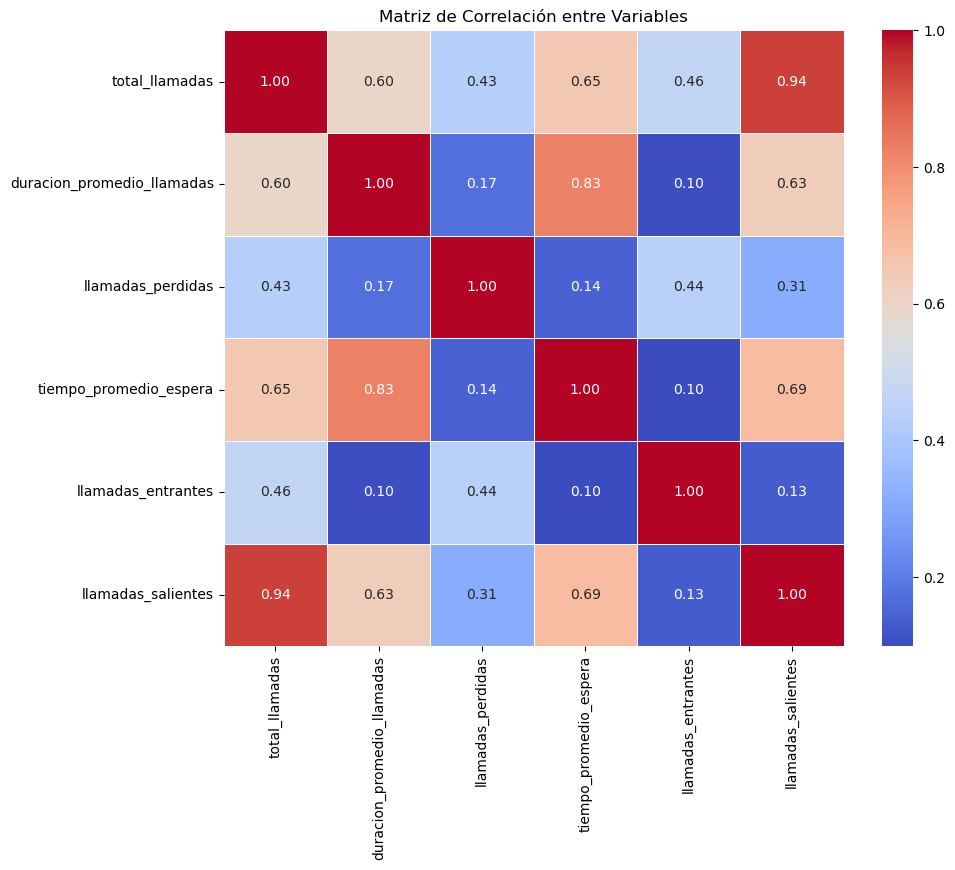

In [1167]:
# Visualizar la matriz de correlación usando un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()

De acuerdo al siguiente mapa de calor se puede apreciar que existe una gran correlación entre llamadas totales y llamadas salientes, esto sugiere que los operadores que manejan un gran numero de llamadas también suelen hacer más llamadas salientes.
Igualmente se puede detectar que la correlación entre el total de llamadas y el tiempo promedio de espera es intermedio, esto puede indicar que aquellos operadores que tienen mas llamadas tienden a ser más largas.
La correlación que se tiene entre las llamadas perdidas y el total de llamadas es moderada, esto puede indicar que los operadores con más llamadas tienden a perder un numero grande de llamadas.

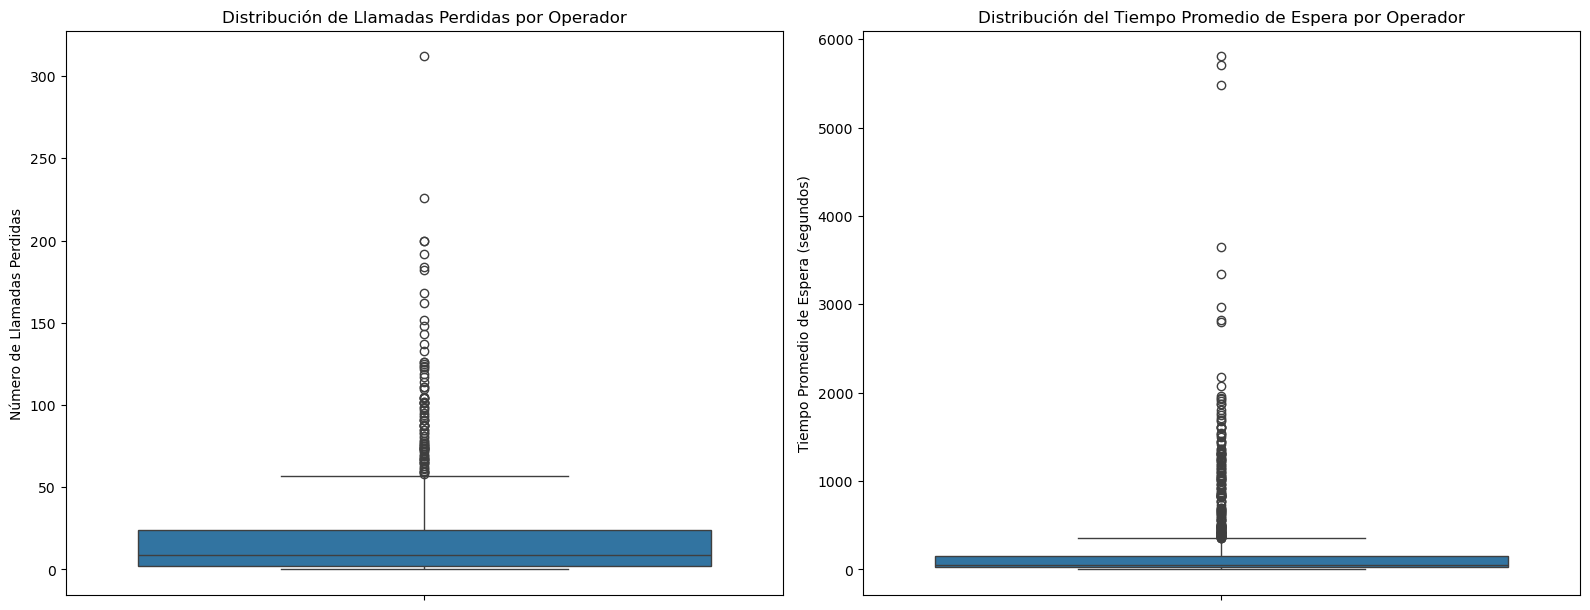

In [1168]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(16, 12))

# Diagrama de caja para 'llamadas_perdidas'
plt.subplot(2, 2, 1)  # Primer gráfico en la misma fila
sns.boxplot(data=operatorsGroup, y='llamadas_perdidas')
plt.title('Distribución de Llamadas Perdidas por Operador')
plt.ylabel('Número de Llamadas Perdidas')

# Diagrama de caja para 'tiempo_promedio_espera'
plt.subplot(2, 2, 2)  # Segundo gráfico en la misma fila
sns.boxplot(data=operatorsGroup, y='tiempo_promedio_espera')
plt.title('Distribución del Tiempo Promedio de Espera por Operador')
plt.ylabel('Tiempo Promedio de Espera (segundos)')

# Mostrar el gráfico
plt.tight_layout()  # Ajustar para que no se sobrepongan los gráficos
plt.show()

Se puede percatar que la media es baja en el numero de llamadas perdidas con lo que una gran parte de operadores no cuentan con una cantidad grande de llamadas perdidas sin embargo se puede tomar como una cantidad grande aquellos que tengan una cantidad mayor a 60 llamadas perdidas sean considerados ineficientes Para el tiempo promedio de espera, por otro lado, también cuenta con una media baja para el tiempo de espera, sin embargo se cuenta con valores que van arriba de los 2000 segundos, equivalente a 33 minutos, así que se puede tomar ese valor para determinar a los operadores ineficientes

Los modelos de clasificación, tanto el árbol de decisión como la regresión logística, demostraron ser altamente eficaces en predecir la eficiencia de los operadores. Con un accuracy del 89% en la regresión logística y reglas claras de clasificación en el árbol de decisión, se logró identificar de manera robusta qué variables tenían mayor influencia en la ineficiencia. Esto respalda la capacidad de estos modelos para ser utilizados en un entorno de producción, donde puedan servir como base para la toma de decisiones en tiempo real.

### Conclusiones y recomendaciones

A partir de los resultados que se obtuvieron en el proyecto, es importante realizar una intervención a los operadores ineficientes brindando capacitaciones, esto puede ir enfocado en estrategias para reducir el numero de llamadas perdidas y mejorar el tiempo de espera con la finalidad de asegurar una mejor atención.
Además se puede reconsiderar la reasignación de los roles a operadores de acuerdo a su desempeño con la finalidad de mejorar la eficiencia operativa.

### Referencias 

Se tuvo preguntas sobre la manipulación de tiempos con formato 00:00:00+03:00, por ello acudimos a la siguiente URL que ayudó a como solucionar un error que se tenia.

https://stackoverflow.com/questions/73056959/pandas-datetime-with-time-format-as-00000-hmmss 

Se tenía preguntas más especificas sobre percentiles, este documento ayudo a dejar más en claro
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html 

Se tenía duda sobre si era apropiado o no utilizar el arbol de decisiones dentro de los modelos predictivos, por ende se investigó más a profundidad

https://lucidspark.com/es/blog/como-hacer-arboles-de-decisiones

Se quería tener más información referente a la normalización de datos, se recurrió a la siguiente fuente

https://www.geeksforgeeks.org/how-to-normalize-data-using-scikit-learn-in-python/ 

Durante el desarrollo del proyecto se mostró un mensaje de error referente al label en la ejecución del modelo predictivo, por ende se buscó más referente al error

https://stackoverflow.com/questions/50203106/valueerror-pos-label-1-is-not-a-valid-label-arrayneg-pos-dtype-u3 error con label 

### URLS

#### Tableau 

https://public.tableau.com/views/Grficollamadas/Dashboard1?:language=es-ES&publish=yes&:sid=77622FF31F874C999769F81EE1961309-0:0&:redirect=auth&:display_count=n&:origin=viz_share_link

#### Presentación 

https://drive.google.com/file/d/1sSO24PRaHQuxfLpw9jpI6X2_yytM5KBI/view?usp=sharing